In [ ]:
# Importing dependencies
from IPython.display import Image, Audio
import scipy.io
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error, accuracy_score
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import mne

# Logistic regression classification of interaction with human and interaction with computer conditions

Successful social interactions rely on the abilities of two or more people to mutually exchange information in
real-time, while simultaneously adapting to one another. But the underlying neural mechanisms remain unknown. In an EEG experiment, we wanted to better understand the neural mechanisms when we engage in interaction with another person, versus with a computer. We thus aimed to predict whether the brain data (recorded with EEG) originated from an experimental condition where participants engaged in interaction with another person, or with a non-responsive computer. The participants were recruited in pairs, and asked to finger tap to a given beat, which would then cease, and they would hear either the other person (interacting with human), or the computer (interaction with computer). Their task was to sycnhronize with their auditory feedback (other person or computer). The other person was thus adaptable, while the computer was not. The computer condition in this experiment was also a metronome, thus not variable. The two experimental conditions are illustrated below.

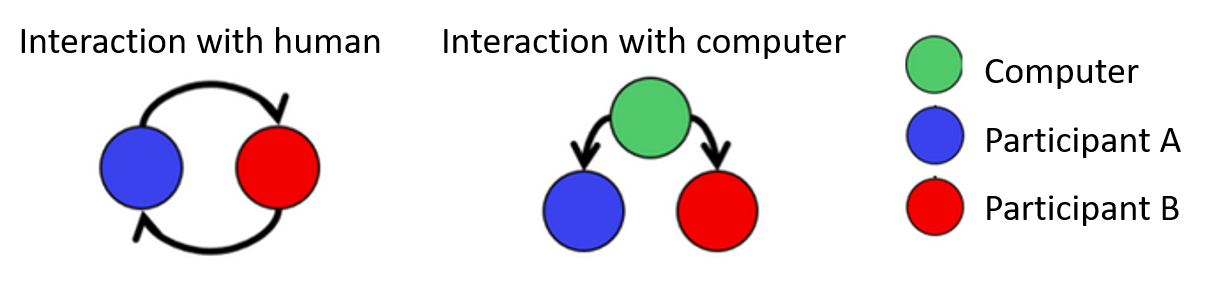

In [6]:
Image("conditions.png",width=700)

EEG data are known to be highly contaminated with noise (artefacts typically originating from muscle and eye movements). Therefore, the given EEG data are already pre-processed, and they represent the 10 Hz power estimates for each electrode (of each person in a pair) for each of the trials. The number of trials is the length of the vector $y$. Power is the squared value of the amplitude of the signal. The data contains power estimates from 60 EEG channels, where 30 belong to participant A and 30 to participant B. This gives a feature matrix $X$, with 60 columns (1 for each feature), and a length the same as the length of the vector $y$. The $y$ vector contains the labels for each trial (1 for the interaction with human condition, 0 for the interaction with computer condition). You have data from 4 pairs (features1.mat, features2.mat, features3.mat, features4.mat, and the corresponding $y$ vectors with condition labels).

In [7]:
# Loading features and labels

feature_mat = scipy.io.loadmat('data/features1.mat')
y1_mat = scipy.io.loadmat('data/y1.mat')
features1 = feature_mat['features1']
y1 = np.array(y1_mat['y1'].T[0])
print('The shape of the X feature matrix is: ' + str(features1.shape))
print('The shape of the y vector is: ' + str(y1.shape))

features_files = ['data/features1.mat', 'data/features2.mat', 'data/features3.mat', 'data/features4.mat']
label_files = ['data/y1.mat', 'data/y2.mat', 'data/y3.mat', 'data/y4.mat']

n_pairs = len(features_files)

features = []
labels = []

#load features and labels from all pairs
#we store them in lists, because they have different number of trials
for i,feature_f in enumerate(features_files):
    feature_map = scipy.io.loadmat(feature_f)
    y_mat = scipy.io.loadmat(label_files[i])
    idx = str(i+1)
    features.append(feature_map[f'features{idx}'])
    labels.append(np.array(y_mat[f'y{idx}'].T[0]))
    assert features[i].shape[0] == labels[i].shape[0] #ensure same n of trials and labels

The shape of the X feature matrix is: (1573, 60)
The shape of the y vector is: (1573,)


Your task is to predict the conditions of the trials from the EEG data (10 Hz power), using a logistic regression classification. This works by fitting a general linear model with a binomial cost and a logit link function. For additional explanation about the intuition of logistic regression see this [video](https://www.youtube.com/watch?v=yIYKR4sgzI8). The logistic regression classification is fitted with a selected subset of the 60 channels (the 30 channels from each member of the pair are grouped together here). The subset of channels are chosen with sequential feature selection. A 10-fold cross validation loop needs to be implemented as well to accurately assess how well the logistic regression model with sequential feature selection performs. 

#### Exercise 1
Your task is for each cross-validation fold to sequentially find the best number of features/channels and use  them to predict with the logistic regression model and calculate the training and test errors. Additionally, make sure to save the selected features in a list for later visualizations. Build-in functions for logistic regression and sequential feature selection in the scikit learn library might be helpful for your implementation.

##### The implementation step-by-step
> * Initially let's predefine some variables. `K = 10` as we want to divide the data into 10 folds. A variable `tol = 1e-6` which is the minimum improvement to the mean squared error (MSE) required to add an additional feature. Two arrays `test_MSE` and `train_MSE` to store the MSE for training and testing in each fold. We define the cross-validation strategy from `sklearn` as `CV = KFold(K,shuffle=True)` and finally an empty list `sfs_features` is defined to save the features found with sequential feature selection.

> * Now you need to set-up the cross-validation loop. Split the matrix `features1` and the vector `y1` into train and test sets using `CV.split`. For inspiration on how to do this see this [tutorial](https://riptutorial.com/scikit-learn/example/27963/k-fold-cross-validation). Furthermore, the `enumerate()` function might be helpful to keep a count variable of the fold number (e.g. `i`).

> * Use `train_index` and `test_index` from `CV.split()` to index the rows designated for test and training in `features1` and `y1` respectively.

> * Add an additional inner loop through the number of features (i.e. 60) and use [SequentialFeatureSelector()](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html) from `sklearn` to find the best features. Feed it [LogisticRegression()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) as estimator and set `n_features_to_select` to the loop parameter (e.g. `j`). This way you can add one feature at a time and check if it causes an improvement greater than `tol`. A boolean with the best `j` parameters is found by fitting `SequentialFeatureSelector()` to the training data and then extracted with the methods `.get_support()`.

> * The logistic regression model LogisticRegression() is then fitted to the best features in the training data. This could be done as \
`model = LogisticRegression()` \
`model.fit(X_train[:,sfs.get_support()], y_train)` \
where `sfs` is your `SequentialFeatureSelector()`. 

> * Use your logistic regression model to predict and calculate the mean squared error (MSE) using [mean_squared_error() ](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html). Now, break the loop if the improvement in the MSE is less than the `tol` variable. If the improvement in MSE is greater than `tol` update a variable storing the best MSE. This variable should be initialized outside the inner loop as an arbitrary large number for example as `best_MSE = 1e3`.

> * Lastly, save training and test MSE for each fold by using the features found with sequential feature selection. Append the boolean of the selected features to the `sfs_features` list. NB! You will need the `sfs_features` list for the exercises next week, where we will visualize and interpret the results.


In [8]:
# Logisitic regression classifier with sequential feature selection
K = 10
tol = 1e-7 # Minimum MSE improvement required to add an additional feature
test_MSE = np.zeros((n_pairs, K))
train_MSE = np.zeros((n_pairs, K))
CV = KFold(K,shuffle=True, random_state=42) #Select Cross-validation strategy
sfs_features = [[] for x in range(n_pairs)] #for saving the best features for each pair and each fold
    
    
#perform CV for each pair
for p in range(n_pairs):
    features_pair = features[p]
    labels_pair = labels[p]
    
    # Cross-validation loop
    for k, (train_index, test_index) in enumerate(CV.split(features_pair)):
        X_train, X_test = features_pair[train_index], features_pair[test_index]
        y_train, y_test = labels_pair[train_index], labels_pair[test_index]

        model = LogisticRegression(max_iter=1000, solver='lbfgs')

        best_test_MSE = 1e3
        best_train_MSE = 1e3
        best_features = None

        for j in range(1, features_pair.shape[1]+1):
            # Sequential Feature Selector
            sfs = SequentialFeatureSelector(model, n_features_to_select=j, direction='forward', scoring='accuracy', cv=3)
            sfs = sfs.fit(X_train, y_train)
            selected_features = sfs.get_support(indices=True)

            # Train model on selected features
            model.fit(X_train[:, selected_features], y_train)

            # Predict on test set
            #y_pred_test = model.predict(X_test[:, selected_features])
            y_pred_test = model.predict_proba(X_test[:, selected_features])[:, 1]
            current_test_MSE = mean_squared_error(y_test, y_pred_test)
            #y_pred_train = model.predict(X_train[:, selected_features])
            y_pred_train = model.predict_proba(X_train[:, selected_features])[:, 1]
            current_train_MSE = mean_squared_error(y_train, y_pred_train)

            improvement = best_test_MSE - current_test_MSE
            if improvement > tol:
                best_test_MSE = current_test_MSE
                best_train_MSE = current_train_MSE
                best_features = selected_features
            else:
                break  # Stop if no significant improvement

        
        test_MSE[p, k] = best_test_MSE
        train_MSE[p, k] = best_train_MSE
        sfs_features[p].append(best_features)
        print(f'Pair {p+1}, Fold {k+1}, Selected {len(best_features)} features, Test MSE: {best_test_MSE}, Train MSE: {best_train_MSE}')
        
print('Average Test MSE for each pair:')
for p in range(n_pairs):
    print(f'Pair {p+1}: {np.mean(test_MSE[p, :])}')



Pair 1, Fold 1, Selected 8 features, Test MSE: 0.07716623498298338, Train MSE: 0.08923894382250395
Pair 1, Fold 2, Selected 4 features, Test MSE: 0.10365642615240409, Train MSE: 0.09119720640834514
Pair 1, Fold 3, Selected 5 features, Test MSE: 0.08818804085251833, Train MSE: 0.09176954965459887
Pair 1, Fold 4, Selected 5 features, Test MSE: 0.09608573165879762, Train MSE: 0.08859182888519379
Pair 1, Fold 5, Selected 10 features, Test MSE: 0.073777990901027, Train MSE: 0.07438646156635814
Pair 1, Fold 6, Selected 5 features, Test MSE: 0.10268174427024819, Train MSE: 0.09042203747819125
Pair 1, Fold 7, Selected 4 features, Test MSE: 0.08726844191631099, Train MSE: 0.09319047942456586
Pair 1, Fold 8, Selected 6 features, Test MSE: 0.08413255136597765, Train MSE: 0.08908889209158011
Pair 1, Fold 9, Selected 8 features, Test MSE: 0.07618287248752789, Train MSE: 0.0926663163905974
Pair 1, Fold 10, Selected 5 features, Test MSE: 0.10520709473859878, Train MSE: 0.08722662297732706
Pair 2, Fol

#### Exercise Part 2

To get a better overview of which features are selected in each cross-validation fold a matrix plot with a row for each feature and a column for each cross-validation fold can be useful.

Plot a matrix of the selected features for each cross validation fold. If there is time, do this for all 4 pairs. 

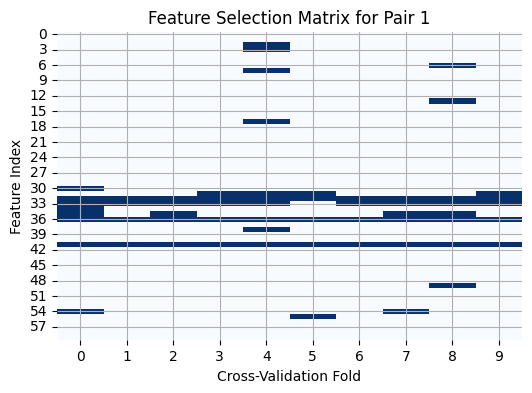

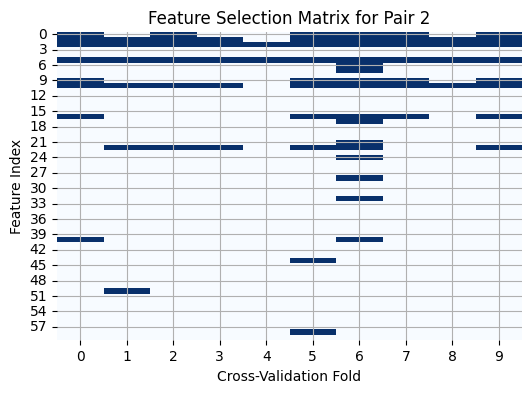

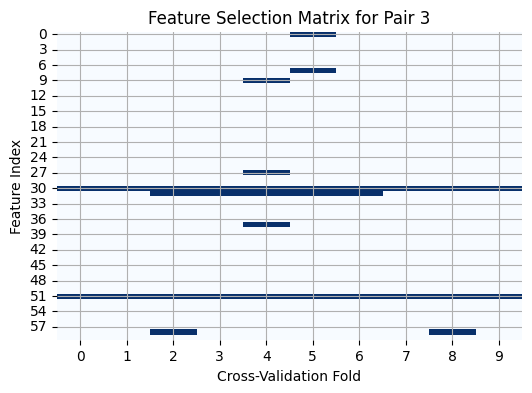

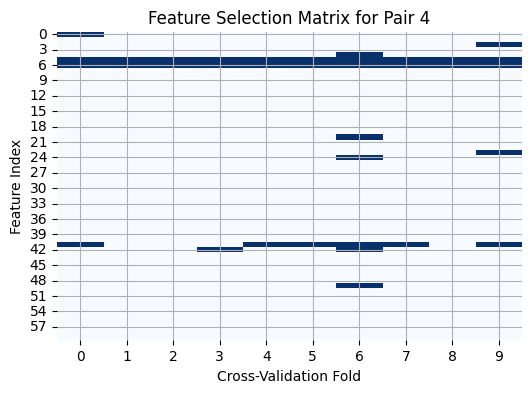

In [14]:
for p in range(n_pairs):
    n_features = features[p].shape[1]
    selection_matrix = np.zeros((n_features, K))

    for k in range(K):
        selected_features = sfs_features[p][k]
        selection_matrix[selected_features, k] = 1

    plt.figure(figsize=(6, 4))
    sns.heatmap(selection_matrix, cmap='Blues', cbar=False)
    plt.title(f'Feature Selection Matrix for Pair {p+1}')
    plt.xlabel('Cross-Validation Fold')
    plt.ylabel('Feature Index')
    plt.grid()
    plt.show()

In [15]:
# Get accuracy
for p in range(n_pairs):
    n_features = features[p].shape[1]
    selection_matrix = np.zeros((n_features, K))

    for k in range(K):
        selected_features = sfs_features[p][k]
        selection_matrix[selected_features, k] = 1

    # Count selections for participant A (features 0-29) and B (features 30-59)
    counts_A = np.sum(selection_matrix[0:30, :])
    counts_B = np.sum(selection_matrix[30:60, :])
    print(f'Pair {p+1}:')
    print(f'Participant A - Selected features count: {counts_A}')
    print(f'Participant B - Selected features count: {counts_B}')




Pair 1:
Participant A - Selected features count: 6.0
Participant B - Selected features count: 54.0
Pair 2:
Participant A - Selected features count: 66.0
Participant B - Selected features count: 6.0
Pair 3:
Participant A - Selected features count: 4.0
Participant B - Selected features count: 28.0
Pair 4:
Participant A - Selected features count: 26.0
Participant B - Selected features count: 9.0


#### Conclusions based on the results

**Summary of results:** <span style="color:gold">This was a binary classification problems, aiming to distinguish between human and computer interactions. We obtained an accuracy of X% on the test set, indicating that our model was able to more or less effectively differentiate between the two types of interactions based on the EEG data using a simple logistic regression.</span>


From the matrix plot we can see that some features are selected in every (or almost every) cross-validation fold, whereas others are more randomly selected. 

The list of the corresponding electrodes from 1-30 (for each person) is as follows: Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, Cz, C4, T8, TP9, CP5, CP1, CP2, CP6, TP10, P7, P3, Pz, P4, P8, O1, Oz, O2.
"F" refers to frontal electrodes; "T" = temporal; "C" = central; "P" = parietal; "O" = occipital; "FC" = fronto-central, etc. 

Looking at the matrices of selected features, do one participant's features seem to be more important for the prediction than the other's? 

**Answer:** <span style="color:gold">Yes, in pair 1, participant B appears to have many features that are relevant for prediction. Similarly, in pair 2, participant A shows a strong contribution. For most of the other participants, however, only a few features seem to be important for prediction. Further within each pair, we also observe that one participant tends to be more dominant in terms of predictive features. This aligns well with the discussion below regarding the leader–follower relationship.</span>

Where are the most selected features situated?

**Answer:** <span style="color:gold">The common pattern is that frontal electrodes tend to be favored as selected features, suggesting that this part of the brain is most relevant (showing the greatest signal differences) when predicting whether an interaction is with another person or a computer. This is seen by the features selected in most of the CV-folds are 0-10 for participant A and 30-40 for participant B. </span>

In this experiment, in each pair one participant emerged as a leader and the other as a follower during the human-interaction. However, in the computer condition, each of the participants followed the computer. The participant in each pair whose features seem to be more important for the prediction was always the leader of the human-interaction. We speculate that the selected features thus tell us something about the neural mechanisms underlying leading behaviour. The follower participant is following in both the human and computer conditions, hence there is less difference in 10 Hz power modulation between the two conditions for this participant. The leading participant, however, follows the computer in the computer-condition, but focuses more on self-generated taps in the human-condition - hence emerging as a "leader" in the interaction.

What can you thus conclude about the neural mechanisms underlying leading behaviour, based on the selected features? 

**Answer:** <span style="color:gold">Based on the selected features, we can conclude that leading behaviour in social interaction is associated with increased neural activity in frontal regions of the brain. Moreover, it could indicate the the leading role comes with a greater cognitive load, as the leader must incorperate more information and can therefore also act as a good predictor which could be why the features are more consistently selected across different contexts. However this is only speculative.</span>


# Similar plots as above, needs testing from Bertram and Alex

Pair 1: total selections participant A = 6, participant B = 54
Pair 2: total selections participant A = 66, participant B = 6
Pair 3: total selections participant A = 4, participant B = 28
Pair 4: total selections participant A = 26, participant B = 9


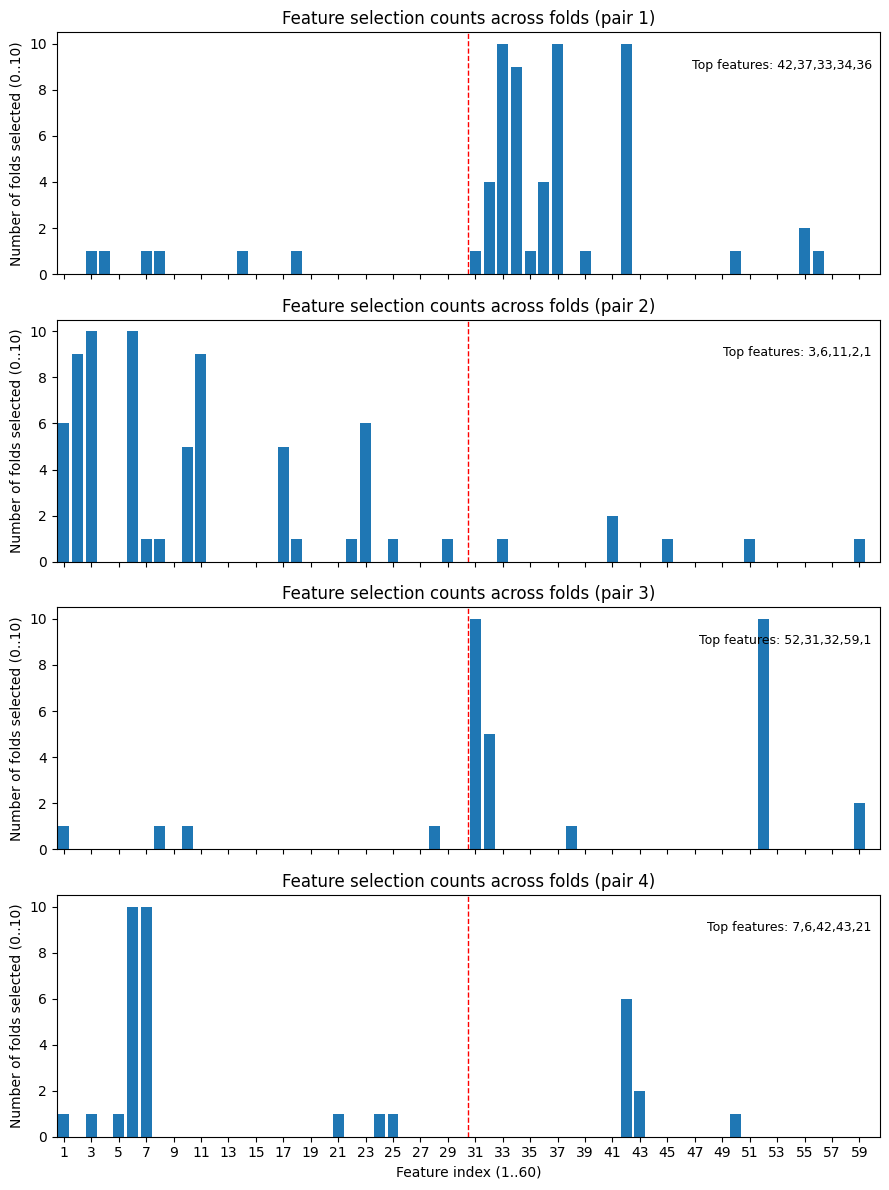

In [25]:
# Plot feature selection counts for all pairs
fig, axes = plt.subplots(n_pairs, 1, figsize=(9, 3 * n_pairs), sharex=True)
if n_pairs == 1:
    axes = [axes]

for p in range(n_pairs):
    n_features = features[p].shape[1]
    selection_matrix = np.zeros((n_features, K))

    for k in range(K):
        try:
            sel = sfs_features[p][k]
            if sel is None or len(sel) == 0:
                continue
            selection_matrix[sel, k] = 1
        except Exception:
            continue

    selection_counts = selection_matrix.sum(axis=1)  # 0..K how many folds selected
    counts_A = int(selection_counts[:30].sum())
    counts_B = int(selection_counts[30:].sum())
    print(f'Pair {p+1}: total selections participant A = {counts_A}, participant B = {counts_B}')

    ax = axes[p]
    ax.bar(np.arange(1, n_features + 1), selection_counts, color='C0')
    ax.axvline(30.5, color='red', linestyle='--', linewidth=1)  # boundary between participants
    ax.set_xlim(0.5, n_features + 0.5)
    ax.set_ylim(0, K + 0.5)
    ax.set_title(f'Feature selection counts across folds (pair {p+1})')
    ax.set_ylabel('Number of folds selected (0..10)')
    # highlight top features
    top_idx = np.argsort(selection_counts)[-5:][::-1] + 1
    ax.set_xticks(np.arange(1, n_features + 1, 2))
    ax.annotate('Top features: ' + ','.join(map(str, top_idx)),
                xy=(0.99, 0.85), xycoords='axes fraction', ha='right', fontsize=9)

axes[-1].set_xlabel('Feature index (1..60)')
plt.tight_layout()
plt.show()

In [16]:
# Proportions per participant:
prop_A = counts_A / (30 * K)
prop_B = counts_B / (30 * K)
print(f'Proportion of times features from participant A selected (all features): {prop_A:.3f}')
print(f'Proportion for participant B: {prop_B:.3f}')

Proportion of times features from participant A selected (all features): 0.087
Proportion for participant B: 0.030


In [22]:


def compute_cv_accuracy(features_list, labels_list, sfs_features, K=10, random_state=42,
                        use_proba_threshold=False, threshold=0.5):
    """Refit LogisticRegression per CV fold using selected features and compute accuracies.

    Args:
        features_list: list of np.arrays, each shape (n_trials, n_features) -- one per pair
        labels_list: list of 1D np.arrays of labels (0/1) -- one per pair
        sfs_features: list (len = n_pairs) where each element is a list/array of length K of
                      selected feature index arrays for each fold (as saved by your SFS step)
        K: number of CV folds (must match how sfs_features was generated)
        random_state: seed used to recreate the KFold splits in the same order
        use_proba_threshold: if True, uses predict_proba >= threshold to form class predictions;
                             otherwise uses model.predict()
        threshold: probability threshold for binary decision when use_proba_threshold is True

    Returns:
        results: dict with keys 'pair_1', 'pair_2', ... each containing:
                 - 'fold_accuracies': list length K of per-fold accuracy (np.nan if no features saved)
                 - 'mean_accuracy': mean accuracy for that pair (ignores NaNs)
                 plus 'overall_mean_accuracy' across all pairs/folds (ignores NaNs)
    """
    CV = KFold(K, shuffle=True, random_state=random_state)
    n_pairs = len(features_list)
    results = {}
    all_pair_fold_acc = []

    for p in range(n_pairs):
        X = features_list[p]
        y = labels_list[p]
        fold_accs = []

        for k, (train_idx, test_idx) in enumerate(CV.split(X)):
            # retrieve selected features for this pair/fold (robust to missing entries)
            try:
                best_feats = sfs_features[p][k]
            except Exception:
                best_feats = None

            # If no features were selected/saved for that fold, record NaN and continue
            if best_feats is None or len(best_feats) == 0:
                fold_accs.append(np.nan)
                continue

            X_train = X[train_idx][:, best_feats]
            X_test = X[test_idx][:, best_feats]
            y_train, y_test = y[train_idx], y[test_idx]

            model = LogisticRegression(max_iter=1000, solver='lbfgs')
            model.fit(X_train, y_train)

            if use_proba_threshold:
                probs = model.predict_proba(X_test)[:, 1]
                y_pred = (probs >= threshold).astype(int)
            else:
                y_pred = model.predict(X_test)

            acc = accuracy_score(y_test, y_pred)
            fold_accs.append(acc)

        all_pair_fold_acc.append(fold_accs)
        results[f'pair_{p+1}'] = {
            'fold_accuracies': fold_accs,
            'mean_accuracy': float(np.nanmean(fold_accs)) if np.any(~np.isnan(fold_accs)) else float('nan')
        }

    # overall mean across all pairs/folds (ignore NaNs)
    flat = np.array([a for pair in all_pair_fold_acc for a in pair if not np.isnan(a)])
    results['overall_mean_accuracy'] = float(np.nanmean(flat)) if flat.size > 0 else float('nan')
    return results


def print_accuracy_summary(results):
    """Pretty-print per-pair and overall accuracies from compute_cv_accuracy output."""
    for k in sorted([kk for kk in results.keys() if kk.startswith('pair_')]):
        accs = results[k]['fold_accuracies']
        print(f"{k}: folds acc = {np.round(accs, 3)}, mean = {results[k]['mean_accuracy']:.3f}")
    print(f"Overall mean accuracy: {results['overall_mean_accuracy']:.3f}")

# Usage example (run after the SFS section):
# res = compute_cv_accuracy(features, labels, sfs_features, K=10, random_state=42)
# print_accuracy_summary(res)


In [21]:
res = compute_cv_accuracy(features, labels, sfs_features, K=10, random_state=42)
print_accuracy_summary(res)

pair_1: folds acc = [0.905 0.873 0.905 0.873 0.917 0.866 0.904 0.911 0.936 0.866], mean = 0.896
pair_2: folds acc = [0.865 0.859 0.821 0.865 0.75  0.904 0.897 0.859 0.853 0.859], mean = 0.853
pair_3: folds acc = [0.975 0.969 0.975 0.988 0.994 0.963 0.975 0.957 0.975 0.963], mean = 0.973
pair_4: folds acc = [0.686 0.718 0.712 0.679 0.673 0.635 0.692 0.724 0.705 0.673], mean = 0.690
Overall mean accuracy: 0.853
